## **Introduction to Image Processing**

Mojdeh Rastgoo - Desire Sidibe

## 3. Interpolation and Blending

 Importing necessary libraries/modules and functions

In [1]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image


Pretty printing has been turned OFF


### 3.1  Resizing an image size using different interpolation functions

** Q.1 Resize the `lena` or `vibot` image using nearest, bilinear and bicubic function.** 

You can define your function which accept the model and resize size from the user or just run a script.

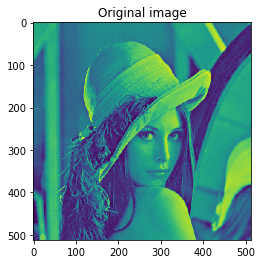

In [10]:
path = './images/'
img_names = ['lena-grey.bmp', 'vibot-color.jpg']

img_lena = io.imread(path + img_names[0])
plt.imshow(img_lena)
plt.title('Original image')
plt.show()

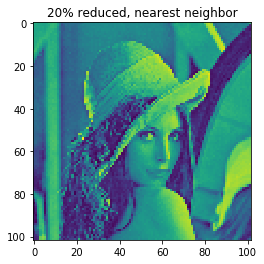

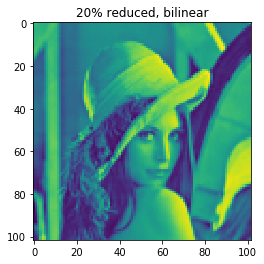

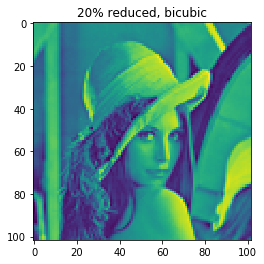

In [9]:
#interp : ‘nearest’, ‘lanczos’, ‘bilinear’, ‘bicubic’ or ‘cubic’
img_lena_20 = misc.imresize(img_lena, 20, interp = 'nearest')
plt.imshow(img_lena_20)
plt.title('20% reduced, nearest neighbor')
plt.show()

img_lena_20 = misc.imresize(img_lena, 20, interp = 'bilinear')
plt.imshow(img_lena_20)
plt.title('20% reduced, bilinear')
plt.show()

img_lena_20 = misc.imresize(img_lena, 20, interp = 'bicubic')
plt.imshow(img_lena_20)
plt.title('20% reduced, bicubic')
plt.show()

**Q.2 Write three functions that performs `simple_blend`, `alpha_blend` and `pyramid_blend`**

** Using your functions, blend `orange` and `apple` images together.**
